In [71]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
#----------------------------
#use fixed point notation
np.set_printoptions(suppress=True)

**output** <br>
1 – caminhada <br>
2 – subindo escadas <br>
3 – descendo escadas <br>
4 – sentado <br>
5 – em pé <br>
6 – deitado <br>
<br>
**one-hot enconding** <br>
[1 0 0 0 0 0]$^T$: walking <br>
[0 1 0 0 0 0]$^T$: climbing stairs <br>
[0 0 1 0 0 0]$^T$: going down stairs <br>
[0 0 0 1 0 0]$^T$: seated <br>
[0 0 0 0 1 0]$^T$: standing <br>
[0 0 0 0 0 1]$^T$: lying <br>


In [2]:
# inputs: y_true, y_pred --> 2D-arrays (N x K)
# output: loss --> zero-one loss (scalar)
def zero_one_loss(y_true, y_pred):
    diff = (y_true - y_pred)
    # if class is right, row has only zeros
    # if class is wrong, real and predicted colums have values 0.5
    half = (diff * diff) / 2
    # sum rows
    row_sum = np.sum(half, axis=1)
    error = np.sum(row_sum)
    loss = error / len(y_true)
    return loss

In [3]:
def max_pooling(y):
    # add one because output must go from 1 to 6
    y = np.argmax(y, axis=1) + 1
    y = y.reshape(-1,1)
    y = one_hot_encoder(y)
    return y

Minkowski distance:

$ \displaystyle d(x,y) = \left( \sum_{i=1}^{K} |x_i - y_i|^p \right)^{1/p}$

For $p = 2$, we have the Euclidian distance:

$ \displaystyle d(x,y) = \sqrt{\sum_{i=1}^{K} |x_i - y_i|^2}$

In [4]:
# inputs: x, y --> 2D-arrays (N x K)
# output: dist --> 2D-array (N x 1)
def minkowski_distance(x, y, p):
    # size of training set
    N = y.shape[0]
    power = np.power((x - y), p)
    dist = np.power( np.sum(power, axis=1), 1/p )
    return dist.reshape(N,1).T

In [19]:
# inputs:
#   - x_test: 2D-array (N x K)
#   - x_train: 2D-array (M x K)
#   - p: order of Minkowski distance (scalar)
# output: 
#   - dist: 2D-array (M x N)
def distance_matrix(x_test, x_train, p):
    N = x_train.shape[0]     # size of training set
    M = x_test.shape[0]      # size of test set
    dist = np.zeros(shape=(M,N))
    for M in range(M):
        # calculate distances between each data in test set and dataset
        dist[M] = minkowski_distance(x_test[M], x_train, 2)
    return dist

In [20]:
def permutation_array(array, permutation):
    sort = np.zeros(shape=array.shape)
    for row in range(array.shape[0]):
        sort[row] = array[row][permutation[row]]
    return sort

$D\_part$: arrays with KN neighbors with smallest distances (M x KN)

$I\_part$: arrays with indexes of KN neighbors with smallest distances (M x KN)

$kn\_out$ shape: (M x KN x C)

In [96]:
def knn(y_train, y_test, D, KN=100, weights='distance', p=2):
    # select array with KN neighbors with smallest distances (UNSORTED)
    D_part = np.partition(D, (KN-1))[:,:KN]
    I_part = np.argpartition(D, (KN-1))[:,:KN]
    #----------------------------
    # discover permutation to order D_part
    permutation = D_part.argsort()
    # apply this permutation to distances and indexes matrix
    D_sort = permutation_array(D_part, permutation)
    I_sort = permutation_array(I_part, permutation)
    I_sort = I_sort.astype(int)
    #----------------------------
    error = []
    for k in range(1,KN):
        # find indexes of KN smallest distances
        index = I_sort[:,:k]
        #----------------------------
        # uniform weights
        if (weights == 'uniform'):
            # check the class for these indexes
            kn_out = y_train[index]
        #----------------------------
        # weight points by the inverse of their distance
        elif (weights == 'distance'):
            M = y_test.shape[0]      # size of test set
            kn_out = y_train[index]
            w = (1/D_sort[:,:k]).reshape(M,k,1)
            kn_out = w * kn_out
        #----------------------------
        # user-defined function
        else:
            # input: array of distances
            # output: array of the same shape containing the weights
            pass
        #----------------------------
        # sum the KN outputs and decide by majority voting
        votes = np.sum(kn_out, axis=1)
        ŷ = max_pooling(votes)
        # calculate zero-one loss
        e = zero_one_loss(y_test, ŷ)
        error.append(e)
    return ŷ, error

In [74]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [22]:
# path to save figures
path = 'figures/ex2-knn/'
# read training data
X_train_df = pd.read_fwf('X_train.txt', header=None)
y_train_df = pd.read_csv('y_train.txt', header=None)
# read test data
X_test_df = pd.read_fwf('X_test.txt', header=None)
y_test_df = pd.read_csv('y_test.txt', header=None)

In [23]:
# convert DataFrame to NumPy array
X_train_raw = X_train_df.to_numpy()
X_test_raw = X_test_df.to_numpy()
y_train_raw = y_train_df.to_numpy()
y_test_raw = y_test_df.to_numpy()

In [24]:
enc = OneHotEncoder(categories='auto')
enc.fit(y_train_raw)
def one_hot_encoder(y):
    return enc.transform(y).toarray()
def one_hot_decoder(y):
    return enc.inverse_transform(y)

In [25]:
# data standardization: x' = (x - u) / s
scaler = StandardScaler()
#----------------------------
# join X_train and X_test
X_set_raw = np.append(X_train_raw, X_test_raw, axis=0)
# perform standardization with x data
scaler.fit(X_set_raw)
X_set = scaler.transform(X_set_raw)
# split X data again in train and test
X_train = X_set[:7352,:]
X_test = X_set[7352:,:]

In [26]:
# one-hot encoding
y_train = one_hot_encoder(y_train_df)
y_test = one_hot_encoder(y_test_df)

In [27]:
# holdout cross-validation
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.33, shuffle=True)

In [28]:
# size of training set
N = X_train_val.shape[0]
# size of test set
M = X_test_val.shape[0]
# number of features
K = X_train_val.shape[1]
# number of classes
C = len(enc.categories_[0])

$D$: distances matrix

$D$ shape: (M x N)
<br>

$ \displaystyle 
D = \begin{bmatrix}
    d(x_{T_0},x_{D_0}) & d(x_{T_0},x_{D_1}) &   ...  & d(x_{T_0},x_{D_N}) \\ 
    d(x_{T_1},x_{D_0}) & d(x_{T_1},x_{D_1}) &   ...  & d(x_{T_1},x_{D_N}) \\ 
           \vdots      &       \vdots       & \ddots &        \vdots      \\
    d(x_{T_M},x_{D_0}) & d(x_{T_M},x_{D_1}) &   ...  & d(x_{T_M},x_{D_N}) \\ 
\end{bmatrix} $

Where:
* $x_{T_M}$ is the M$^{th}$ sample of training set
* $x_{D_N}$ is the N$^{th}$ sample of data set
* $d(x_{T_M},x_{D_N})$ is the Minkowski distance between the points $x_{T_M}$ and $x_{D_N}$

In [29]:
# calculate distances matrix
D = distance_matrix(X_test_val, X_train_val, 2)

In [30]:
# define neighbors
KN = 100
# training with uniform weights
error_uniform = knn(y_train_val, y_test_val, D, KN, weights='uniform')[1]
# training with distance weights
error_distance = knn(y_train_val, y_test_val, D, KN, weights='distance')[1]

# Selecting the hyperparameter

In [31]:
# calculate distances matrix
D = distance_matrix(X_test, X_train, 2)

In [128]:
y_true = y_test_raw
# classes to be plot in confusion matrix
classes = np.array(['walking','climbing stairs','going down stairs','seated','standing','lying'])

- ## Uniform Weights

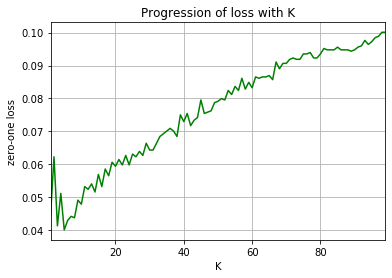

In [129]:
# plots
plt.plot(range(1,100), error_uniform, 'green')
plt.xlabel('K')
plt.ylabel('zero-one loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of loss with K')
plt.grid(True)
plt.savefig(path + 'error_uniform', dpi=300)
plt.show()

In [130]:
k_best_uniform = error_uniform.index(min(error_uniform)) + 1
print('k for minimun error (uniform weights) =', k_best_uniform)

k for minimun error (uniform weights) = 5


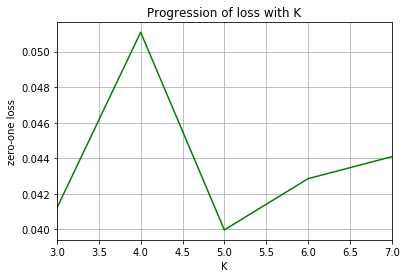

In [131]:
# plots
#plt.plot(range(10,15), error[10:15])
plt.plot(range(max(1,k_best_uniform-2),min(KN,k_best_uniform+3)), error_uniform[max(1,k_best_uniform-3):min(KN,k_best_uniform+2)], 'green')
plt.xlabel('K')
plt.ylabel('zero-one loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of loss with K')
plt.grid(True)
plt.savefig(path + 'error_uniform_(zoom)', dpi=300)
plt.show()

- ## Weights inversely proportional to distance

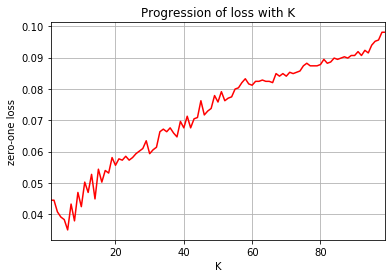

In [132]:
# plots
plt.plot(range(1,100), error_distance, 'red')
plt.xlabel('K')
plt.ylabel('zero-one loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of loss with K')
plt.grid(True)
plt.savefig(path + 'error_distance', dpi=300)
plt.show()

In [133]:
k_best_distance = error_distance.index(min(error_distance)) + 1
print('k for minimun error (distance weights) =', k_best_distance)

k for minimun error (distance weights) = 6


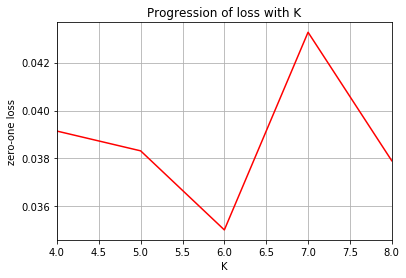

In [134]:
# plots
#plt.plot(range(10,15), error[10:15])
plt.plot(range(max(1,k_best_distance-2),min(KN,k_best_distance+3)), error_distance[max(1,k_best_distance-3):min(KN,k_best_distance+2)], 'red')
plt.xlabel('K')
plt.ylabel('zero-one loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of loss with K')
plt.grid(True)
plt.savefig(path + 'error_distance_(zoom)', dpi=300)
plt.show()

# Testing the model

### Confusion Matrix (uniform weights)

In [135]:
y_pred, error = knn(y_train, y_test, D, k_best_uniform, weights='uniform')
y_pred = one_hot_decoder(max_pooling(y_pred))
cm = confusion_matrix(y_test_raw, y_pred)

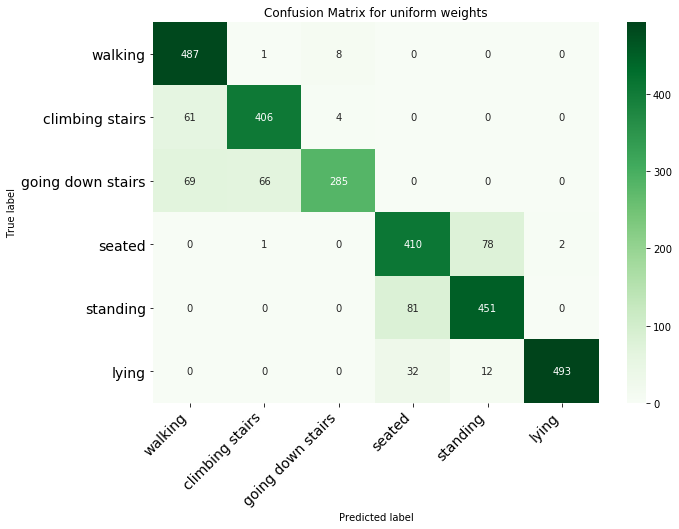

In [136]:
# CM uniform weights raw
cm_uniform_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix for uniform weights', normalize=False, cmap=plt.cm.Greens)
cm_uniform_raw.savefig(path + 'cm_uniform', dpi=300, bbox_inches='tight')

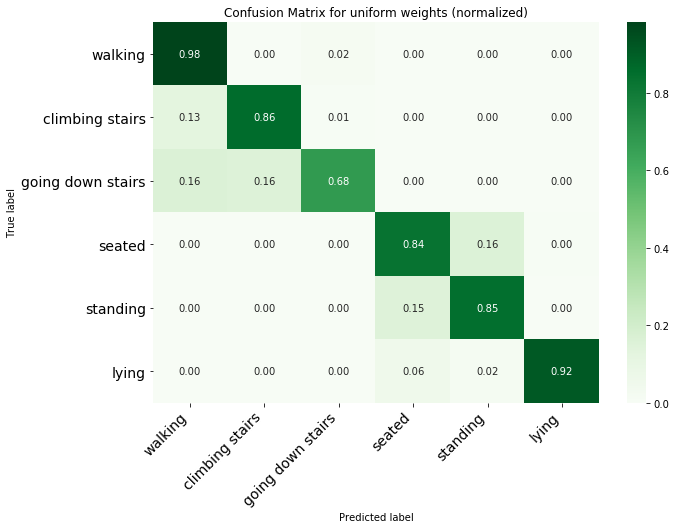

In [137]:
# CM uniform weights normalized
cm_uniform_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix for uniform weights (normalized)', normalize=True, cmap=plt.cm.Greens)
cm_uniform_norm.savefig(path + 'cm_uniform_normalized', dpi=300, bbox_inches='tight')

### F1-score (uniform weights)

In [138]:
macro_u = f1_score(y_true, y_pred, average='macro')
micro_u = f1_score(y_true, y_pred, average='micro')
weighted_u = f1_score(y_true, y_pred, average='weighted')

In [139]:
print('F1-score macro =', macro_u)
print('F1-score micro =', micro_u)
print('F1-score weighted =', weighted_u)

F1-score macro = 0.8556815404320904
F1-score micro = 0.8591788259246692
F1-score weighted = 0.8585002631341973


In [140]:
loss_uniform = zero_one_loss(y_true, y_pred)
print('Zero-one loss =', loss_uniform)

Zero-one loss = 0.12741771292840176


### Confusion Matrix (distance weights)

In [141]:
y_pred, error = knn(y_train, y_test, D, k_best_distance, weights='distance')
y_pred = one_hot_decoder(max_pooling(y_pred))
cm = confusion_matrix(y_test_raw, y_pred)

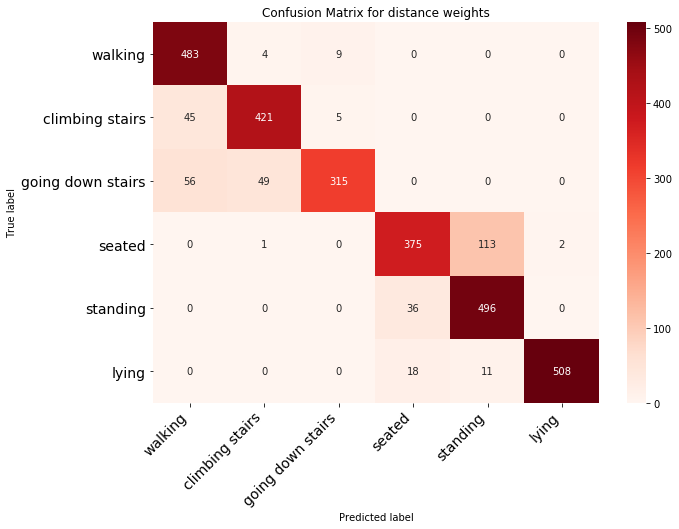

In [142]:
# CM distance weights raw
cm_distance_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix for distance weights', normalize=False, cmap=plt.cm.Reds)
cm_distance_raw.savefig(path + 'cm_distance', dpi=300, bbox_inches='tight')

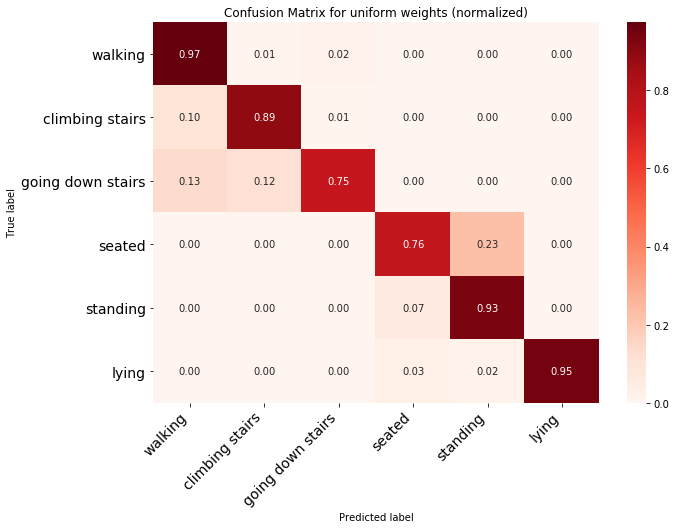

In [143]:
# CM distance weights normalized
cm_distance_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix for uniform weights (normalized)', normalize=True, cmap=plt.cm.Reds)
cm_distance_norm.savefig(path + 'cm_distance_normalized', dpi=300, bbox_inches='tight')

### F1-score (distance weights)

In [144]:
macro_d = f1_score(y_true, y_pred, average='macro')
micro_d = f1_score(y_true, y_pred, average='micro')
weighted_d = f1_score(y_true, y_pred, average='weighted')

In [145]:
print('F1-score macro =', macro_d)
print('F1-score micro =', micro_d)
print('F1-score weighted =', weighted_d)

F1-score macro = 0.8787249103612634
F1-score micro = 0.8815744825246012
F1-score weighted = 0.880766366612294


In [146]:
loss_distance = zero_one_loss(y_true, y_pred)
print('Zero-one loss =', loss_distance)

Zero-one loss = 0.10298608754665761
